In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=rates_equal)) # 0-1
    targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/miniconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:1.3905 dloss:3.5979 glossQ:1.0007 dlossQ:0.3822 exploreP:0.9979
Episode:1 meanR:18.0000 R:15.0000 rate:0.0300 gloss:1.3873 dloss:3.5859 glossQ:1.0010 dlossQ:0.3701 exploreP:0.9964
Episode:2 meanR:17.6667 R:17.0000 rate:0.0340 gloss:1.3872 dloss:3.5732 glossQ:1.0011 dlossQ:0.3904 exploreP:0.9948
Episode:3 meanR:18.2500 R:20.0000 rate:0.0400 gloss:1.3848 dloss:3.5639 glossQ:1.0019 dlossQ:0.3810 exploreP:0.9928
Episode:4 meanR:17.4000 R:14.0000 rate:0.0280 gloss:1.3819 dloss:3.5513 glossQ:1.0027 dlossQ:0.3788 exploreP:0.9914
Episode:5 meanR:20.3333 R:35.0000 rate:0.0700 gloss:1.3798 dloss:3.5329 glossQ:1.0032 dlossQ:0.3888 exploreP:0.9880
Episode:6 meanR:20.4286 R:21.0000 rate:0.0420 gloss:1.3764 dloss:3.5166 glossQ:1.0039 dlossQ:0.3904 exploreP:0.9859
Episode:7 meanR:19.2500 R:11.0000 rate:0.0220 gloss:1.3767 dloss:3.5042 glossQ:1.0042 dlossQ:0.4070 exploreP:0.9849
Episode:8 meanR:18.6667 R:14.0000 rate:0.0280 gloss:1.3741 dloss:3.4955 

Episode:71 meanR:23.2083 R:36.0000 rate:0.0720 gloss:1.2734 dloss:2.8840 glossQ:1.0710 dlossQ:0.7761 exploreP:0.8477
Episode:72 meanR:23.0548 R:12.0000 rate:0.0240 gloss:1.2918 dloss:2.9198 glossQ:1.0674 dlossQ:0.7804 exploreP:0.8466
Episode:73 meanR:23.1081 R:27.0000 rate:0.0540 gloss:1.2692 dloss:2.8703 glossQ:1.0703 dlossQ:0.8002 exploreP:0.8444
Episode:74 meanR:23.3333 R:40.0000 rate:0.0800 gloss:1.2754 dloss:2.8769 glossQ:1.0831 dlossQ:0.8345 exploreP:0.8411
Episode:75 meanR:23.3684 R:26.0000 rate:0.0520 gloss:1.2647 dloss:2.8594 glossQ:1.0901 dlossQ:0.8578 exploreP:0.8389
Episode:76 meanR:23.3117 R:19.0000 rate:0.0380 gloss:1.2922 dloss:2.9142 glossQ:1.0669 dlossQ:0.8765 exploreP:0.8373
Episode:77 meanR:23.4359 R:33.0000 rate:0.0660 gloss:1.2594 dloss:2.8402 glossQ:1.0743 dlossQ:0.8597 exploreP:0.8346
Episode:78 meanR:23.4937 R:28.0000 rate:0.0560 gloss:1.2645 dloss:2.8491 glossQ:1.0703 dlossQ:0.8576 exploreP:0.8323
Episode:79 meanR:23.3750 R:14.0000 rate:0.0280 gloss:1.2727 dlos

Episode:141 meanR:21.8400 R:11.0000 rate:0.0220 gloss:1.2182 dloss:2.6908 glossQ:1.1078 dlossQ:1.1128 exploreP:0.7346
Episode:142 meanR:21.7100 R:10.0000 rate:0.0200 gloss:1.2100 dloss:2.6721 glossQ:1.1038 dlossQ:1.0940 exploreP:0.7339
Episode:143 meanR:21.8500 R:33.0000 rate:0.0660 gloss:1.2184 dloss:2.6849 glossQ:1.1021 dlossQ:1.0620 exploreP:0.7315
Episode:144 meanR:22.3300 R:73.0000 rate:0.1460 gloss:1.2163 dloss:2.6741 glossQ:1.1056 dlossQ:1.0340 exploreP:0.7262
Episode:145 meanR:22.3700 R:14.0000 rate:0.0280 gloss:1.2122 dloss:2.6570 glossQ:1.1054 dlossQ:0.9822 exploreP:0.7252
Episode:146 meanR:22.5000 R:27.0000 rate:0.0540 gloss:1.2206 dloss:2.6774 glossQ:1.0964 dlossQ:0.9710 exploreP:0.7233
Episode:147 meanR:22.2100 R:19.0000 rate:0.0380 gloss:1.2070 dloss:2.6482 glossQ:1.1042 dlossQ:0.9639 exploreP:0.7219
Episode:148 meanR:22.1900 R:13.0000 rate:0.0260 gloss:1.2190 dloss:2.6630 glossQ:1.1049 dlossQ:0.9641 exploreP:0.7210
Episode:149 meanR:22.1200 R:17.0000 rate:0.0340 gloss:1.

Episode:211 meanR:17.7500 R:11.0000 rate:0.0220 gloss:1.2194 dloss:2.7005 glossQ:1.0989 dlossQ:1.0357 exploreP:0.6521
Episode:212 meanR:17.8300 R:19.0000 rate:0.0380 gloss:1.2175 dloss:2.7037 glossQ:1.0926 dlossQ:1.0516 exploreP:0.6509
Episode:213 meanR:17.6700 R:12.0000 rate:0.0240 gloss:1.2314 dloss:2.7281 glossQ:1.0908 dlossQ:1.0301 exploreP:0.6501
Episode:214 meanR:17.6300 R:14.0000 rate:0.0280 gloss:1.2153 dloss:2.6979 glossQ:1.0990 dlossQ:1.0357 exploreP:0.6492
Episode:215 meanR:17.5500 R:9.0000 rate:0.0180 gloss:1.2283 dloss:2.7214 glossQ:1.0959 dlossQ:1.0392 exploreP:0.6486
Episode:216 meanR:17.5900 R:14.0000 rate:0.0280 gloss:1.2230 dloss:2.7138 glossQ:1.0925 dlossQ:1.0313 exploreP:0.6477
Episode:217 meanR:17.5500 R:10.0000 rate:0.0200 gloss:1.2173 dloss:2.7041 glossQ:1.0978 dlossQ:1.0252 exploreP:0.6471
Episode:218 meanR:17.6000 R:17.0000 rate:0.0340 gloss:1.2075 dloss:2.6785 glossQ:1.1042 dlossQ:1.0560 exploreP:0.6460
Episode:219 meanR:17.2800 R:11.0000 rate:0.0220 gloss:1.2

Episode:281 meanR:13.9100 R:14.0000 rate:0.0280 gloss:1.2130 dloss:2.6800 glossQ:1.1002 dlossQ:0.8930 exploreP:0.5934
Episode:282 meanR:13.9000 R:10.0000 rate:0.0200 gloss:1.2159 dloss:2.6850 glossQ:1.0986 dlossQ:0.8892 exploreP:0.5928
Episode:283 meanR:13.8700 R:10.0000 rate:0.0200 gloss:1.2371 dloss:2.7275 glossQ:1.0964 dlossQ:0.8586 exploreP:0.5923
Episode:284 meanR:13.9300 R:16.0000 rate:0.0320 gloss:1.2336 dloss:2.7120 glossQ:1.0911 dlossQ:0.8709 exploreP:0.5913
Episode:285 meanR:13.9800 R:16.0000 rate:0.0320 gloss:1.2138 dloss:2.6763 glossQ:1.1012 dlossQ:0.8792 exploreP:0.5904
Episode:286 meanR:13.8500 R:10.0000 rate:0.0200 gloss:1.2130 dloss:2.6690 glossQ:1.1217 dlossQ:0.8725 exploreP:0.5898
Episode:287 meanR:13.8700 R:13.0000 rate:0.0260 gloss:1.2273 dloss:2.7047 glossQ:1.0953 dlossQ:0.8615 exploreP:0.5891
Episode:288 meanR:13.8700 R:8.0000 rate:0.0160 gloss:1.1967 dloss:2.6417 glossQ:1.1090 dlossQ:0.8730 exploreP:0.5886
Episode:289 meanR:13.8500 R:11.0000 rate:0.0220 gloss:1.2

Episode:351 meanR:13.3400 R:14.0000 rate:0.0280 gloss:1.2164 dloss:2.6661 glossQ:1.0994 dlossQ:0.8155 exploreP:0.5407
Episode:352 meanR:13.3200 R:12.0000 rate:0.0240 gloss:1.2089 dloss:2.6439 glossQ:1.0879 dlossQ:0.7842 exploreP:0.5400
Episode:353 meanR:13.3500 R:14.0000 rate:0.0280 gloss:1.2047 dloss:2.6350 glossQ:1.1144 dlossQ:0.8463 exploreP:0.5393
Episode:354 meanR:13.3900 R:16.0000 rate:0.0320 gloss:1.2145 dloss:2.6538 glossQ:1.0996 dlossQ:0.8589 exploreP:0.5384
Episode:355 meanR:13.3800 R:10.0000 rate:0.0200 gloss:1.2080 dloss:2.6427 glossQ:1.1040 dlossQ:0.7991 exploreP:0.5379
Episode:356 meanR:13.4600 R:20.0000 rate:0.0400 gloss:1.2117 dloss:2.6532 glossQ:1.0924 dlossQ:0.8119 exploreP:0.5368
Episode:357 meanR:13.4900 R:15.0000 rate:0.0300 gloss:1.2107 dloss:2.6508 glossQ:1.1150 dlossQ:0.8792 exploreP:0.5361
Episode:358 meanR:13.5100 R:12.0000 rate:0.0240 gloss:1.2226 dloss:2.6668 glossQ:1.0953 dlossQ:0.7972 exploreP:0.5354
Episode:359 meanR:13.5300 R:16.0000 rate:0.0320 gloss:1.

Episode:421 meanR:14.4900 R:15.0000 rate:0.0300 gloss:1.1636 dloss:2.4780 glossQ:1.1331 dlossQ:0.6614 exploreP:0.4902
Episode:422 meanR:14.4700 R:13.0000 rate:0.0260 gloss:1.1766 dloss:2.4994 glossQ:1.1184 dlossQ:0.6518 exploreP:0.4896
Episode:423 meanR:14.4500 R:11.0000 rate:0.0220 gloss:1.1768 dloss:2.5059 glossQ:1.1579 dlossQ:0.6850 exploreP:0.4890
Episode:424 meanR:14.4400 R:16.0000 rate:0.0320 gloss:1.1717 dloss:2.4740 glossQ:1.1860 dlossQ:0.7196 exploreP:0.4883
Episode:425 meanR:14.4500 R:10.0000 rate:0.0200 gloss:1.2068 dloss:2.4964 glossQ:1.4093 dlossQ:0.8425 exploreP:0.4878
Episode:426 meanR:14.3800 R:14.0000 rate:0.0280 gloss:1.1784 dloss:2.5123 glossQ:1.1274 dlossQ:0.6735 exploreP:0.4871
Episode:427 meanR:14.4500 R:16.0000 rate:0.0320 gloss:1.1399 dloss:2.4356 glossQ:1.1493 dlossQ:0.6774 exploreP:0.4864
Episode:428 meanR:14.4100 R:9.0000 rate:0.0180 gloss:1.1608 dloss:2.4782 glossQ:1.1195 dlossQ:0.6560 exploreP:0.4859
Episode:429 meanR:14.2900 R:13.0000 rate:0.0260 gloss:1.1

Episode:491 meanR:21.7000 R:22.0000 rate:0.0440 gloss:1.2266 dloss:2.7004 glossQ:1.1434 dlossQ:1.2335 exploreP:0.4128
Episode:492 meanR:21.8400 R:33.0000 rate:0.0660 gloss:1.2270 dloss:2.7038 glossQ:1.1230 dlossQ:1.1847 exploreP:0.4115
Episode:493 meanR:22.0100 R:30.0000 rate:0.0600 gloss:1.2233 dloss:2.6909 glossQ:1.1151 dlossQ:1.1412 exploreP:0.4103
Episode:494 meanR:22.1900 R:30.0000 rate:0.0600 gloss:1.2200 dloss:2.6825 glossQ:1.1433 dlossQ:1.1643 exploreP:0.4091
Episode:495 meanR:22.4600 R:37.0000 rate:0.0740 gloss:1.2426 dloss:2.7250 glossQ:1.1106 dlossQ:1.0965 exploreP:0.4076
Episode:496 meanR:22.6900 R:33.0000 rate:0.0660 gloss:1.2274 dloss:2.7054 glossQ:1.1231 dlossQ:1.1327 exploreP:0.4063
Episode:497 meanR:22.7800 R:20.0000 rate:0.0400 gloss:1.2191 dloss:2.6852 glossQ:1.1250 dlossQ:1.1198 exploreP:0.4055
Episode:498 meanR:23.0200 R:36.0000 rate:0.0720 gloss:1.2236 dloss:2.6923 glossQ:1.1107 dlossQ:1.0853 exploreP:0.4041
Episode:499 meanR:23.4800 R:58.0000 rate:0.1160 gloss:1.

Episode:561 meanR:58.3100 R:61.0000 rate:0.1220 gloss:1.2338 dloss:2.7101 glossQ:1.1119 dlossQ:0.9780 exploreP:0.2632
Episode:562 meanR:58.9600 R:83.0000 rate:0.1660 gloss:1.2214 dloss:2.6879 glossQ:1.1064 dlossQ:0.9727 exploreP:0.2611
Episode:563 meanR:59.1600 R:34.0000 rate:0.0680 gloss:1.2395 dloss:2.7201 glossQ:1.0967 dlossQ:0.9616 exploreP:0.2602
Episode:564 meanR:59.7800 R:77.0000 rate:0.1540 gloss:1.2389 dloss:nan glossQ:1.1439 dlossQ:1.0130 exploreP:0.2583
Episode:565 meanR:60.3200 R:69.0000 rate:0.1380 gloss:1.2218 dloss:2.6894 glossQ:1.1056 dlossQ:0.9659 exploreP:0.2566
Episode:566 meanR:61.2300 R:117.0000 rate:0.2340 gloss:1.2293 dloss:2.7013 glossQ:1.1026 dlossQ:0.9603 exploreP:0.2537
Episode:567 meanR:61.7400 R:78.0000 rate:0.1560 gloss:1.2235 dloss:nan glossQ:1.1029 dlossQ:0.9684 exploreP:0.2518
Episode:568 meanR:62.4100 R:91.0000 rate:0.1820 gloss:1.2280 dloss:2.6995 glossQ:1.1004 dlossQ:0.9623 exploreP:0.2497
Episode:569 meanR:62.8200 R:62.0000 rate:0.1240 gloss:1.2244 

Episode:631 meanR:81.8800 R:70.0000 rate:0.1400 gloss:1.2594 dloss:2.7997 glossQ:1.1023 dlossQ:1.0190 exploreP:0.1497
Episode:632 meanR:83.1100 R:171.0000 rate:0.3420 gloss:1.2673 dloss:nan glossQ:1.1144 dlossQ:1.0240 exploreP:0.1473
Episode:633 meanR:83.1900 R:78.0000 rate:0.1560 gloss:1.2722 dloss:nan glossQ:1.0837 dlossQ:0.9892 exploreP:0.1463
Episode:634 meanR:83.2800 R:100.0000 rate:0.2000 gloss:1.2769 dloss:2.8305 glossQ:1.0820 dlossQ:0.9848 exploreP:0.1449
Episode:635 meanR:82.7200 R:58.0000 rate:0.1160 gloss:1.2709 dloss:2.8252 glossQ:1.1054 dlossQ:1.0079 exploreP:0.1441
Episode:636 meanR:84.0200 R:182.0000 rate:0.3640 gloss:1.2724 dloss:nan glossQ:1.1244 dlossQ:1.0291 exploreP:0.1417
Episode:637 meanR:83.9200 R:46.0000 rate:0.0920 gloss:1.2485 dloss:nan glossQ:1.0895 dlossQ:0.9964 exploreP:0.1411
Episode:638 meanR:84.5200 R:118.0000 rate:0.2360 gloss:1.2718 dloss:2.8203 glossQ:1.0837 dlossQ:0.9856 exploreP:0.1396
Episode:639 meanR:84.7500 R:84.0000 rate:0.1680 gloss:1.2812 dlo

Episode:701 meanR:87.8100 R:63.0000 rate:0.1260 gloss:1.2866 dloss:2.8608 glossQ:1.0837 dlossQ:0.9745 exploreP:0.0841
Episode:702 meanR:89.0900 R:186.0000 rate:0.3720 gloss:1.2771 dloss:2.8433 glossQ:1.0839 dlossQ:0.9775 exploreP:0.0827
Episode:703 meanR:88.6900 R:93.0000 rate:0.1860 gloss:1.2795 dloss:2.8429 glossQ:1.0899 dlossQ:0.9855 exploreP:0.0820
Episode:704 meanR:89.4500 R:181.0000 rate:0.3620 gloss:1.2842 dloss:nan glossQ:1.0842 dlossQ:0.9774 exploreP:0.0807
Episode:705 meanR:89.1800 R:56.0000 rate:0.1120 gloss:1.2864 dloss:nan glossQ:1.1165 dlossQ:0.9819 exploreP:0.0804
Episode:706 meanR:89.8400 R:115.0000 rate:0.2300 gloss:1.2989 dloss:2.8884 glossQ:1.0860 dlossQ:0.9746 exploreP:0.0795
Episode:707 meanR:89.7500 R:59.0000 rate:0.1180 gloss:1.2744 dloss:2.8431 glossQ:1.0803 dlossQ:0.9695 exploreP:0.0791
Episode:708 meanR:90.7600 R:157.0000 rate:0.3140 gloss:1.2889 dloss:2.8733 glossQ:1.0843 dlossQ:0.9832 exploreP:0.0781
Episode:709 meanR:92.2300 R:212.0000 rate:0.4240 gloss:1.2

Episode:771 meanR:101.7500 R:71.0000 rate:0.1420 gloss:1.3088 dloss:nan glossQ:1.0704 dlossQ:0.9953 exploreP:0.0458
Episode:772 meanR:100.4600 R:82.0000 rate:0.1640 gloss:1.3096 dloss:nan glossQ:1.0744 dlossQ:0.9870 exploreP:0.0455
Episode:773 meanR:100.5800 R:87.0000 rate:0.1740 gloss:1.3399 dloss:nan glossQ:1.0672 dlossQ:0.9828 exploreP:0.0452
Episode:774 meanR:101.2900 R:120.0000 rate:0.2400 gloss:1.3457 dloss:nan glossQ:1.0693 dlossQ:0.9854 exploreP:0.0448
Episode:775 meanR:101.4400 R:111.0000 rate:0.2220 gloss:1.3086 dloss:2.9476 glossQ:1.0782 dlossQ:0.9819 exploreP:0.0444
Episode:776 meanR:101.4900 R:97.0000 rate:0.1940 gloss:1.3127 dloss:2.9516 glossQ:1.0740 dlossQ:0.9888 exploreP:0.0440
Episode:777 meanR:101.9500 R:119.0000 rate:0.2380 gloss:1.3310 dloss:nan glossQ:1.0698 dlossQ:0.9832 exploreP:0.0436
Episode:778 meanR:102.0900 R:85.0000 rate:0.1700 gloss:1.3209 dloss:2.9670 glossQ:1.0749 dlossQ:0.9779 exploreP:0.0434
Episode:779 meanR:103.2700 R:197.0000 rate:0.3940 gloss:1.32

Episode:841 meanR:167.1600 R:115.0000 rate:0.2300 gloss:1.3955 dloss:3.2111 glossQ:1.0448 dlossQ:0.9983 exploreP:0.0193
Episode:842 meanR:167.5800 R:169.0000 rate:0.3380 gloss:1.3547 dloss:3.1176 glossQ:1.0492 dlossQ:0.9912 exploreP:0.0191
Episode:843 meanR:164.2500 R:130.0000 rate:0.2600 gloss:1.4102 dloss:nan glossQ:1.0525 dlossQ:1.0027 exploreP:0.0190
Episode:844 meanR:168.4600 R:500.0000 rate:1.0000 gloss:1.3918 dloss:nan glossQ:1.0494 dlossQ:0.9987 exploreP:0.0186
Episode:845 meanR:169.3500 R:161.0000 rate:0.3220 gloss:1.3942 dloss:3.1932 glossQ:1.0497 dlossQ:0.9915 exploreP:0.0184
Episode:846 meanR:171.0000 R:274.0000 rate:0.5480 gloss:1.4239 dloss:nan glossQ:1.0451 dlossQ:0.9948 exploreP:0.0182
Episode:847 meanR:172.3900 R:220.0000 rate:0.4400 gloss:1.3979 dloss:nan glossQ:1.0428 dlossQ:0.9912 exploreP:0.0180
Episode:848 meanR:173.2900 R:168.0000 rate:0.3360 gloss:1.4133 dloss:3.2562 glossQ:1.0455 dlossQ:0.9939 exploreP:0.0179
Episode:849 meanR:172.8700 R:112.0000 rate:0.2240 gl

Episode:911 meanR:166.2200 R:146.0000 rate:0.2920 gloss:1.4245 dloss:nan glossQ:1.0359 dlossQ:1.0169 exploreP:0.0133
Episode:912 meanR:166.7600 R:349.0000 rate:0.6980 gloss:1.4180 dloss:nan glossQ:1.0362 dlossQ:1.0210 exploreP:0.0131
Episode:913 meanR:166.8000 R:253.0000 rate:0.5060 gloss:1.4121 dloss:nan glossQ:1.0373 dlossQ:1.0165 exploreP:0.0131
Episode:914 meanR:165.0200 R:135.0000 rate:0.2700 gloss:1.4130 dloss:nan glossQ:1.0337 dlossQ:1.0151 exploreP:0.0130
Episode:915 meanR:169.0600 R:496.0000 rate:0.9920 gloss:1.4150 dloss:nan glossQ:1.0396 dlossQ:1.0244 exploreP:0.0129
Episode:916 meanR:168.1200 R:167.0000 rate:0.3340 gloss:1.4069 dloss:nan glossQ:1.0370 dlossQ:1.0181 exploreP:0.0128
Episode:917 meanR:169.8100 R:256.0000 rate:0.5120 gloss:1.4216 dloss:3.3307 glossQ:1.0312 dlossQ:1.0141 exploreP:0.0128
Episode:918 meanR:171.0700 R:318.0000 rate:0.6360 gloss:1.4193 dloss:nan glossQ:1.0315 dlossQ:1.0212 exploreP:0.0127
Episode:919 meanR:172.5900 R:262.0000 rate:0.5240 gloss:1.427

Episode:981 meanR:239.8700 R:188.0000 rate:0.3760 gloss:1.4109 dloss:nan glossQ:1.0151 dlossQ:1.0445 exploreP:0.0105
Episode:982 meanR:240.3800 R:138.0000 rate:0.2760 gloss:1.4056 dloss:nan glossQ:1.0156 dlossQ:1.0534 exploreP:0.0105
Episode:983 meanR:241.8600 R:239.0000 rate:0.4780 gloss:1.4009 dloss:nan glossQ:1.0123 dlossQ:1.0526 exploreP:0.0105
Episode:984 meanR:242.8200 R:192.0000 rate:0.3840 gloss:1.3972 dloss:nan glossQ:1.0161 dlossQ:1.0528 exploreP:0.0105
Episode:985 meanR:243.8900 R:335.0000 rate:0.6700 gloss:1.4056 dloss:nan glossQ:1.0130 dlossQ:1.0429 exploreP:0.0105
Episode:986 meanR:247.9800 R:500.0000 rate:1.0000 gloss:1.3995 dloss:nan glossQ:1.0160 dlossQ:1.0616 exploreP:0.0104
Episode:987 meanR:249.8600 R:500.0000 rate:1.0000 gloss:1.4009 dloss:nan glossQ:1.0203 dlossQ:1.0555 exploreP:0.0104
Episode:988 meanR:250.8500 R:212.0000 rate:0.4240 gloss:1.4027 dloss:nan glossQ:1.0190 dlossQ:1.0498 exploreP:0.0104
Episode:989 meanR:253.7100 R:500.0000 rate:1.0000 gloss:1.4002 d

Episode:1051 meanR:254.2800 R:220.0000 rate:0.4400 gloss:1.3288 dloss:nan glossQ:1.0042 dlossQ:1.0665 exploreP:0.0101
Episode:1052 meanR:251.6900 R:163.0000 rate:0.3260 gloss:1.3193 dloss:nan glossQ:1.0051 dlossQ:1.0968 exploreP:0.0101
Episode:1053 meanR:252.5900 R:287.0000 rate:0.5740 gloss:1.3115 dloss:nan glossQ:1.0014 dlossQ:1.0922 exploreP:0.0101
Episode:1054 meanR:251.8200 R:423.0000 rate:0.8460 gloss:1.3239 dloss:nan glossQ:1.0030 dlossQ:1.0944 exploreP:0.0101
Episode:1055 meanR:251.1700 R:150.0000 rate:0.3000 gloss:1.3160 dloss:nan glossQ:1.0003 dlossQ:1.0779 exploreP:0.0101
Episode:1056 meanR:250.2900 R:412.0000 rate:0.8240 gloss:1.3219 dloss:nan glossQ:1.0060 dlossQ:1.0975 exploreP:0.0101
Episode:1057 meanR:250.7100 R:198.0000 rate:0.3960 gloss:1.3250 dloss:nan glossQ:1.0022 dlossQ:1.0801 exploreP:0.0101
Episode:1058 meanR:251.2400 R:172.0000 rate:0.3440 gloss:1.3060 dloss:nan glossQ:1.0030 dlossQ:1.0638 exploreP:0.0101
Episode:1059 meanR:251.3500 R:170.0000 rate:0.3400 gloss

Episode:1121 meanR:200.0900 R:227.0000 rate:0.4540 gloss:1.2492 dloss:3.3521 glossQ:1.0343 dlossQ:1.2313 exploreP:0.0100
Episode:1122 meanR:200.0500 R:142.0000 rate:0.2840 gloss:1.2638 dloss:nan glossQ:1.0106 dlossQ:1.1550 exploreP:0.0100
Episode:1123 meanR:199.7700 R:222.0000 rate:0.4440 gloss:1.2555 dloss:nan glossQ:1.0128 dlossQ:1.1284 exploreP:0.0100
Episode:1124 meanR:199.9700 R:259.0000 rate:0.5180 gloss:1.2467 dloss:nan glossQ:1.0194 dlossQ:1.2170 exploreP:0.0100
Episode:1125 meanR:196.0300 R:106.0000 rate:0.2120 gloss:1.1910 dloss:3.2529 glossQ:1.0434 dlossQ:1.2999 exploreP:0.0100
Episode:1126 meanR:195.2000 R:108.0000 rate:0.2160 gloss:1.1964 dloss:3.2799 glossQ:1.0542 dlossQ:1.3377 exploreP:0.0100
Episode:1127 meanR:194.4000 R:130.0000 rate:0.2600 gloss:1.2084 dloss:nan glossQ:1.0586 dlossQ:1.3376 exploreP:0.0100
Episode:1128 meanR:192.7600 R:138.0000 rate:0.2760 gloss:1.2051 dloss:nan glossQ:1.0302 dlossQ:1.3277 exploreP:0.0100
Episode:1129 meanR:191.2500 R:142.0000 rate:0.2

Episode:1191 meanR:151.7500 R:152.0000 rate:0.3040 gloss:1.1758 dloss:nan glossQ:1.0375 dlossQ:1.3416 exploreP:0.0100
Episode:1192 meanR:151.0000 R:98.0000 rate:0.1960 gloss:1.1881 dloss:nan glossQ:1.0624 dlossQ:1.4052 exploreP:0.0100
Episode:1193 meanR:152.4900 R:288.0000 rate:0.5760 gloss:1.1975 dloss:nan glossQ:1.0285 dlossQ:1.3152 exploreP:0.0100
Episode:1194 meanR:151.4000 R:115.0000 rate:0.2300 gloss:1.1426 dloss:nan glossQ:1.0482 dlossQ:1.3731 exploreP:0.0100
Episode:1195 meanR:151.6400 R:151.0000 rate:0.3020 gloss:1.1900 dloss:3.3121 glossQ:1.0075 dlossQ:1.2481 exploreP:0.0100
Episode:1196 meanR:151.7600 R:165.0000 rate:0.3300 gloss:1.1636 dloss:nan glossQ:1.0225 dlossQ:1.3253 exploreP:0.0100
Episode:1197 meanR:151.7100 R:110.0000 rate:0.2200 gloss:1.1439 dloss:nan glossQ:1.0441 dlossQ:1.3817 exploreP:0.0100
Episode:1198 meanR:151.6500 R:96.0000 rate:0.1920 gloss:1.1504 dloss:3.2665 glossQ:1.0336 dlossQ:1.3759 exploreP:0.0100
Episode:1199 meanR:153.6700 R:385.0000 rate:0.7700 g

Episode:1261 meanR:152.2500 R:130.0000 rate:0.2600 gloss:1.1433 dloss:nan glossQ:1.0769 dlossQ:1.5064 exploreP:0.0100
Episode:1262 meanR:152.8200 R:125.0000 rate:0.2500 gloss:1.1273 dloss:nan glossQ:1.1058 dlossQ:1.5471 exploreP:0.0100
Episode:1263 meanR:153.4300 R:216.0000 rate:0.4320 gloss:1.1299 dloss:nan glossQ:1.0689 dlossQ:1.4667 exploreP:0.0100
Episode:1264 meanR:153.1300 R:173.0000 rate:0.3460 gloss:1.1358 dloss:nan glossQ:1.0764 dlossQ:1.5057 exploreP:0.0100
Episode:1265 meanR:152.6600 R:110.0000 rate:0.2200 gloss:1.1060 dloss:nan glossQ:1.0908 dlossQ:1.5189 exploreP:0.0100
Episode:1266 meanR:151.2800 R:146.0000 rate:0.2920 gloss:1.1588 dloss:nan glossQ:1.0633 dlossQ:1.3921 exploreP:0.0100
Episode:1267 meanR:150.6400 R:134.0000 rate:0.2680 gloss:1.1526 dloss:nan glossQ:1.0550 dlossQ:1.4026 exploreP:0.0100
Episode:1268 meanR:149.8000 R:116.0000 rate:0.2320 gloss:1.1050 dloss:nan glossQ:1.1457 dlossQ:1.5673 exploreP:0.0100
Episode:1269 meanR:150.3100 R:150.0000 rate:0.3000 gloss

Episode:1331 meanR:150.1700 R:131.0000 rate:0.2620 gloss:1.1763 dloss:nan glossQ:1.1481 dlossQ:1.1924 exploreP:0.0100
Episode:1332 meanR:151.8200 R:226.0000 rate:0.4520 gloss:1.1756 dloss:nan glossQ:1.1362 dlossQ:1.1418 exploreP:0.0100
Episode:1333 meanR:152.0100 R:122.0000 rate:0.2440 gloss:1.1906 dloss:nan glossQ:1.1650 dlossQ:1.2170 exploreP:0.0100
Episode:1334 meanR:153.1700 R:154.0000 rate:0.3080 gloss:1.1897 dloss:3.2346 glossQ:1.1673 dlossQ:1.1985 exploreP:0.0100
Episode:1335 meanR:153.5500 R:152.0000 rate:0.3040 gloss:1.1600 dloss:nan glossQ:1.2025 dlossQ:1.2701 exploreP:0.0100
Episode:1336 meanR:154.8600 R:182.0000 rate:0.3640 gloss:1.1555 dloss:nan glossQ:1.2063 dlossQ:1.2553 exploreP:0.0100
Episode:1337 meanR:154.3600 R:114.0000 rate:0.2280 gloss:1.1166 dloss:nan glossQ:1.2012 dlossQ:1.2075 exploreP:0.0100
Episode:1338 meanR:153.8600 R:98.0000 rate:0.1960 gloss:1.1944 dloss:nan glossQ:1.1152 dlossQ:1.0813 exploreP:0.0100
Episode:1339 meanR:153.2000 R:48.0000 rate:0.0960 glos

Episode:1401 meanR:151.1500 R:184.0000 rate:0.3680 gloss:1.2612 dloss:nan glossQ:1.3252 dlossQ:1.0587 exploreP:0.0100
Episode:1402 meanR:150.9500 R:114.0000 rate:0.2280 gloss:1.2614 dloss:3.1984 glossQ:1.2598 dlossQ:0.9742 exploreP:0.0100
Episode:1403 meanR:150.9900 R:122.0000 rate:0.2440 gloss:1.2725 dloss:nan glossQ:1.3344 dlossQ:1.0418 exploreP:0.0100
Episode:1404 meanR:152.5000 R:193.0000 rate:0.3860 gloss:1.2239 dloss:nan glossQ:1.3888 dlossQ:1.1780 exploreP:0.0100
Episode:1405 meanR:153.3300 R:204.0000 rate:0.4080 gloss:1.2219 dloss:nan glossQ:1.3756 dlossQ:1.1779 exploreP:0.0100
Episode:1406 meanR:153.6900 R:160.0000 rate:0.3200 gloss:1.2761 dloss:nan glossQ:1.2934 dlossQ:0.9816 exploreP:0.0100
Episode:1407 meanR:153.8600 R:132.0000 rate:0.2640 gloss:1.2789 dloss:3.2456 glossQ:1.3109 dlossQ:1.0730 exploreP:0.0100
Episode:1408 meanR:154.1600 R:187.0000 rate:0.3740 gloss:1.2617 dloss:nan glossQ:1.3674 dlossQ:1.1971 exploreP:0.0100
Episode:1409 meanR:153.9000 R:142.0000 rate:0.2840

Episode:1471 meanR:149.7500 R:171.0000 rate:0.3420 gloss:1.2574 dloss:nan glossQ:1.2898 dlossQ:1.0816 exploreP:0.0100
Episode:1472 meanR:149.2900 R:123.0000 rate:0.2460 gloss:1.2796 dloss:nan glossQ:1.2535 dlossQ:1.0132 exploreP:0.0100
Episode:1473 meanR:149.1700 R:103.0000 rate:0.2060 gloss:1.2868 dloss:nan glossQ:1.2430 dlossQ:0.9792 exploreP:0.0100
Episode:1474 meanR:149.0300 R:116.0000 rate:0.2320 gloss:1.2709 dloss:3.2481 glossQ:1.2865 dlossQ:1.0665 exploreP:0.0100
Episode:1475 meanR:148.8200 R:101.0000 rate:0.2020 gloss:1.2424 dloss:nan glossQ:1.4008 dlossQ:1.2518 exploreP:0.0100
Episode:1476 meanR:149.3700 R:178.0000 rate:0.3560 gloss:1.2665 dloss:nan glossQ:1.3112 dlossQ:1.1055 exploreP:0.0100
Episode:1477 meanR:149.4800 R:177.0000 rate:0.3540 gloss:1.2925 dloss:nan glossQ:1.3070 dlossQ:1.1062 exploreP:0.0100
Episode:1478 meanR:148.8400 R:70.0000 rate:0.1400 gloss:1.2853 dloss:nan glossQ:1.2514 dlossQ:1.0428 exploreP:0.0100
Episode:1479 meanR:148.9100 R:124.0000 rate:0.2480 glo

Episode:1541 meanR:117.2300 R:115.0000 rate:0.2300 gloss:1.3193 dloss:nan glossQ:1.2768 dlossQ:1.0395 exploreP:0.0100
Episode:1542 meanR:116.5800 R:118.0000 rate:0.2360 gloss:1.3189 dloss:nan glossQ:1.2762 dlossQ:1.0512 exploreP:0.0100
Episode:1543 meanR:115.4900 R:69.0000 rate:0.1380 gloss:1.2951 dloss:nan glossQ:1.2888 dlossQ:1.1235 exploreP:0.0100
Episode:1544 meanR:115.7800 R:179.0000 rate:0.3580 gloss:1.3165 dloss:nan glossQ:1.1954 dlossQ:0.9341 exploreP:0.0100
Episode:1545 meanR:115.8700 R:139.0000 rate:0.2780 gloss:1.3036 dloss:nan glossQ:1.3071 dlossQ:1.0645 exploreP:0.0100
Episode:1546 meanR:114.1400 R:52.0000 rate:0.1040 gloss:1.3276 dloss:3.2884 glossQ:1.1697 dlossQ:0.8260 exploreP:0.0100
Episode:1547 meanR:112.7100 R:11.0000 rate:0.0220 gloss:1.3069 dloss:3.2709 glossQ:1.1649 dlossQ:0.8866 exploreP:0.0100
Episode:1548 meanR:112.3200 R:152.0000 rate:0.3040 gloss:1.3138 dloss:nan glossQ:1.2171 dlossQ:0.9215 exploreP:0.0100
Episode:1549 meanR:112.9800 R:183.0000 rate:0.3660 gl

Episode:1611 meanR:98.8400 R:72.0000 rate:0.1440 gloss:1.3360 dloss:nan glossQ:1.2330 dlossQ:1.0831 exploreP:0.0100
Episode:1612 meanR:99.2800 R:154.0000 rate:0.3080 gloss:1.3367 dloss:nan glossQ:1.2170 dlossQ:1.0521 exploreP:0.0100
Episode:1613 meanR:99.0200 R:116.0000 rate:0.2320 gloss:1.3499 dloss:nan glossQ:1.2016 dlossQ:1.0316 exploreP:0.0100
Episode:1614 meanR:99.9700 R:135.0000 rate:0.2700 gloss:1.3490 dloss:nan glossQ:1.1956 dlossQ:1.0278 exploreP:0.0100
Episode:1615 meanR:99.4000 R:46.0000 rate:0.0920 gloss:1.3716 dloss:nan glossQ:1.3411 dlossQ:1.2304 exploreP:0.0100
Episode:1616 meanR:100.6300 R:149.0000 rate:0.2980 gloss:1.3415 dloss:nan glossQ:1.2365 dlossQ:1.0719 exploreP:0.0100
Episode:1617 meanR:99.8900 R:9.0000 rate:0.0180 gloss:1.3303 dloss:3.3049 glossQ:1.1982 dlossQ:1.0821 exploreP:0.0100
Episode:1618 meanR:99.3800 R:51.0000 rate:0.1020 gloss:1.3506 dloss:nan glossQ:1.2023 dlossQ:1.0483 exploreP:0.0100
Episode:1619 meanR:99.4500 R:151.0000 rate:0.3020 gloss:1.3647 dl

Episode:1681 meanR:117.4400 R:95.0000 rate:0.1900 gloss:1.3814 dloss:nan glossQ:1.2198 dlossQ:1.1459 exploreP:0.0100
Episode:1682 meanR:117.7900 R:169.0000 rate:0.3380 gloss:1.3682 dloss:nan glossQ:1.2334 dlossQ:1.1535 exploreP:0.0100
Episode:1683 meanR:117.9700 R:114.0000 rate:0.2280 gloss:1.3683 dloss:nan glossQ:1.2256 dlossQ:1.1276 exploreP:0.0100
Episode:1684 meanR:117.7500 R:126.0000 rate:0.2520 gloss:1.3706 dloss:nan glossQ:1.2289 dlossQ:1.1664 exploreP:0.0100
Episode:1685 meanR:118.4600 R:245.0000 rate:0.4900 gloss:1.3726 dloss:nan glossQ:1.2434 dlossQ:1.1768 exploreP:0.0100
Episode:1686 meanR:117.9200 R:128.0000 rate:0.2560 gloss:1.3913 dloss:nan glossQ:1.2108 dlossQ:1.0729 exploreP:0.0100
Episode:1687 meanR:117.6300 R:143.0000 rate:0.2860 gloss:1.3908 dloss:nan glossQ:1.2544 dlossQ:1.0975 exploreP:0.0100
Episode:1688 meanR:118.5700 R:112.0000 rate:0.2240 gloss:1.3719 dloss:nan glossQ:1.2433 dlossQ:1.1532 exploreP:0.0100
Episode:1689 meanR:119.3800 R:98.0000 rate:0.1960 gloss:1

Episode:1751 meanR:140.5600 R:137.0000 rate:0.2740 gloss:1.4009 dloss:nan glossQ:1.2597 dlossQ:1.1860 exploreP:0.0100
Episode:1752 meanR:141.8700 R:266.0000 rate:0.5320 gloss:1.4121 dloss:nan glossQ:1.2029 dlossQ:1.0054 exploreP:0.0100
Episode:1753 meanR:142.1500 R:147.0000 rate:0.2940 gloss:1.3981 dloss:nan glossQ:1.2371 dlossQ:1.1410 exploreP:0.0100
Episode:1754 meanR:141.7500 R:103.0000 rate:0.2060 gloss:1.4035 dloss:nan glossQ:1.2385 dlossQ:1.1294 exploreP:0.0100
Episode:1755 meanR:142.1900 R:136.0000 rate:0.2720 gloss:1.3949 dloss:nan glossQ:1.2320 dlossQ:1.1084 exploreP:0.0100
Episode:1756 meanR:142.0900 R:170.0000 rate:0.3400 gloss:1.4002 dloss:nan glossQ:1.2516 dlossQ:1.0988 exploreP:0.0100
Episode:1757 meanR:141.4500 R:103.0000 rate:0.2060 gloss:1.4034 dloss:nan glossQ:1.2354 dlossQ:1.1209 exploreP:0.0100
Episode:1758 meanR:141.8000 R:130.0000 rate:0.2600 gloss:1.4020 dloss:nan glossQ:1.2669 dlossQ:1.1125 exploreP:0.0100
Episode:1759 meanR:142.1900 R:186.0000 rate:0.3720 gloss

Episode:1821 meanR:152.6600 R:152.0000 rate:0.3040 gloss:1.4108 dloss:nan glossQ:1.1717 dlossQ:1.1329 exploreP:0.0100
Episode:1822 meanR:152.1600 R:131.0000 rate:0.2620 gloss:1.4084 dloss:nan glossQ:1.1453 dlossQ:1.0785 exploreP:0.0100
Episode:1823 meanR:152.1300 R:123.0000 rate:0.2460 gloss:1.4111 dloss:nan glossQ:1.1904 dlossQ:1.1991 exploreP:0.0100
Episode:1824 meanR:152.2500 R:122.0000 rate:0.2440 gloss:1.4047 dloss:nan glossQ:1.1728 dlossQ:1.1582 exploreP:0.0100
Episode:1825 meanR:151.9700 R:172.0000 rate:0.3440 gloss:1.4049 dloss:nan glossQ:1.1615 dlossQ:1.1262 exploreP:0.0100
Episode:1826 meanR:151.9500 R:184.0000 rate:0.3680 gloss:1.4137 dloss:nan glossQ:1.1835 dlossQ:1.1864 exploreP:0.0100
Episode:1827 meanR:153.2200 R:225.0000 rate:0.4500 gloss:1.4050 dloss:nan glossQ:1.1466 dlossQ:1.0816 exploreP:0.0100
Episode:1828 meanR:153.3400 R:109.0000 rate:0.2180 gloss:1.4047 dloss:nan glossQ:1.1664 dlossQ:1.1459 exploreP:0.0100
Episode:1829 meanR:154.1300 R:210.0000 rate:0.4200 gloss

Episode:1891 meanR:155.9200 R:125.0000 rate:0.2500 gloss:1.4118 dloss:nan glossQ:1.1505 dlossQ:1.0471 exploreP:0.0100
Episode:1892 meanR:156.4300 R:169.0000 rate:0.3380 gloss:1.4180 dloss:nan glossQ:1.1535 dlossQ:1.0581 exploreP:0.0100
Episode:1893 meanR:156.9300 R:181.0000 rate:0.3620 gloss:1.4115 dloss:nan glossQ:1.1820 dlossQ:1.1142 exploreP:0.0100
Episode:1894 meanR:157.1700 R:150.0000 rate:0.3000 gloss:1.4174 dloss:nan glossQ:1.1559 dlossQ:1.0392 exploreP:0.0100
Episode:1895 meanR:157.1400 R:106.0000 rate:0.2120 gloss:1.4197 dloss:nan glossQ:1.1589 dlossQ:1.0781 exploreP:0.0100
Episode:1896 meanR:157.6100 R:200.0000 rate:0.4000 gloss:1.4207 dloss:nan glossQ:1.1495 dlossQ:1.0362 exploreP:0.0100
Episode:1897 meanR:157.3000 R:140.0000 rate:0.2800 gloss:1.4169 dloss:nan glossQ:1.1532 dlossQ:1.0553 exploreP:0.0100
Episode:1898 meanR:155.9300 R:155.0000 rate:0.3100 gloss:1.4180 dloss:nan glossQ:1.1676 dlossQ:1.0953 exploreP:0.0100
Episode:1899 meanR:155.2900 R:149.0000 rate:0.2980 gloss

Episode:1961 meanR:159.9600 R:157.0000 rate:0.3140 gloss:1.4193 dloss:nan glossQ:1.2142 dlossQ:1.2231 exploreP:0.0100
Episode:1962 meanR:160.5200 R:156.0000 rate:0.3120 gloss:1.4272 dloss:nan glossQ:1.1692 dlossQ:1.1282 exploreP:0.0100
Episode:1963 meanR:160.4000 R:123.0000 rate:0.2460 gloss:1.4191 dloss:nan glossQ:1.1459 dlossQ:1.0617 exploreP:0.0100
Episode:1964 meanR:160.8300 R:141.0000 rate:0.2820 gloss:1.4153 dloss:nan glossQ:1.1695 dlossQ:1.1145 exploreP:0.0100
Episode:1965 meanR:161.5000 R:200.0000 rate:0.4000 gloss:1.4193 dloss:nan glossQ:1.1825 dlossQ:1.1470 exploreP:0.0100
Episode:1966 meanR:160.7700 R:123.0000 rate:0.2460 gloss:1.4180 dloss:nan glossQ:1.1927 dlossQ:1.1760 exploreP:0.0100
Episode:1967 meanR:161.0600 R:272.0000 rate:0.5440 gloss:1.4204 dloss:nan glossQ:1.1798 dlossQ:1.1148 exploreP:0.0100
Episode:1968 meanR:160.9700 R:137.0000 rate:0.2740 gloss:1.4226 dloss:nan glossQ:1.1944 dlossQ:1.1531 exploreP:0.0100
Episode:1969 meanR:160.6800 R:164.0000 rate:0.3280 gloss

Episode:2031 meanR:174.2200 R:170.0000 rate:0.3400 gloss:1.4188 dloss:nan glossQ:1.1466 dlossQ:1.0522 exploreP:0.0100
Episode:2032 meanR:173.8600 R:112.0000 rate:0.2240 gloss:1.4280 dloss:nan glossQ:1.1795 dlossQ:1.1085 exploreP:0.0100
Episode:2033 meanR:174.4600 R:197.0000 rate:0.3940 gloss:1.4252 dloss:nan glossQ:1.1906 dlossQ:1.1443 exploreP:0.0100
Episode:2034 meanR:173.5000 R:90.0000 rate:0.1800 gloss:1.4247 dloss:nan glossQ:1.1883 dlossQ:1.1591 exploreP:0.0100
Episode:2035 meanR:173.4300 R:219.0000 rate:0.4380 gloss:1.4194 dloss:nan glossQ:1.1871 dlossQ:1.1753 exploreP:0.0100
Episode:2036 meanR:172.4200 R:132.0000 rate:0.2640 gloss:1.4210 dloss:nan glossQ:1.1684 dlossQ:1.1153 exploreP:0.0100
Episode:2037 meanR:172.4600 R:144.0000 rate:0.2880 gloss:1.4266 dloss:nan glossQ:1.1688 dlossQ:1.1281 exploreP:0.0100
Episode:2038 meanR:172.4900 R:145.0000 rate:0.2900 gloss:1.4247 dloss:nan glossQ:1.1629 dlossQ:1.1074 exploreP:0.0100
Episode:2039 meanR:172.6800 R:193.0000 rate:0.3860 gloss:

Episode:2101 meanR:165.9100 R:183.0000 rate:0.3660 gloss:1.4216 dloss:nan glossQ:1.1774 dlossQ:1.1180 exploreP:0.0100
Episode:2102 meanR:166.2700 R:167.0000 rate:0.3340 gloss:1.4215 dloss:nan glossQ:1.1705 dlossQ:1.1159 exploreP:0.0100
Episode:2103 meanR:166.7000 R:217.0000 rate:0.4340 gloss:1.4175 dloss:nan glossQ:1.1802 dlossQ:1.1083 exploreP:0.0100
Episode:2104 meanR:166.1600 R:117.0000 rate:0.2340 gloss:1.4160 dloss:nan glossQ:1.1681 dlossQ:1.0684 exploreP:0.0100
Episode:2105 meanR:166.5500 R:169.0000 rate:0.3380 gloss:1.4204 dloss:nan glossQ:1.1757 dlossQ:1.1310 exploreP:0.0100
Episode:2106 meanR:166.8500 R:160.0000 rate:0.3200 gloss:1.4221 dloss:nan glossQ:1.1664 dlossQ:1.0993 exploreP:0.0100
Episode:2107 meanR:167.2700 R:180.0000 rate:0.3600 gloss:1.4235 dloss:nan glossQ:1.1784 dlossQ:1.1442 exploreP:0.0100
Episode:2108 meanR:167.4100 R:121.0000 rate:0.2420 gloss:1.4219 dloss:nan glossQ:1.1869 dlossQ:1.1711 exploreP:0.0100
Episode:2109 meanR:167.0300 R:111.0000 rate:0.2220 gloss

Episode:2171 meanR:158.9300 R:208.0000 rate:0.4160 gloss:1.4164 dloss:nan glossQ:1.1657 dlossQ:1.1257 exploreP:0.0100
Episode:2172 meanR:159.0100 R:178.0000 rate:0.3560 gloss:1.4231 dloss:nan glossQ:1.1664 dlossQ:1.1196 exploreP:0.0100
Episode:2173 meanR:158.3200 R:111.0000 rate:0.2220 gloss:1.4242 dloss:nan glossQ:1.1746 dlossQ:1.1149 exploreP:0.0100
Episode:2174 meanR:157.8200 R:108.0000 rate:0.2160 gloss:1.4194 dloss:nan glossQ:1.1683 dlossQ:1.0376 exploreP:0.0100
Episode:2175 meanR:157.6600 R:172.0000 rate:0.3440 gloss:1.4191 dloss:nan glossQ:1.1656 dlossQ:1.0768 exploreP:0.0100
Episode:2176 meanR:158.0900 R:162.0000 rate:0.3240 gloss:1.4208 dloss:nan glossQ:1.1671 dlossQ:1.0796 exploreP:0.0100
Episode:2177 meanR:158.5800 R:172.0000 rate:0.3440 gloss:1.4235 dloss:nan glossQ:1.1824 dlossQ:1.1285 exploreP:0.0100
Episode:2178 meanR:158.4300 R:210.0000 rate:0.4200 gloss:1.4195 dloss:nan glossQ:1.1862 dlossQ:1.1589 exploreP:0.0100
Episode:2179 meanR:159.1800 R:202.0000 rate:0.4040 gloss

Episode:2241 meanR:157.5400 R:131.0000 rate:0.2620 gloss:1.4263 dloss:nan glossQ:1.1627 dlossQ:1.0501 exploreP:0.0100
Episode:2242 meanR:157.9200 R:226.0000 rate:0.4520 gloss:1.4182 dloss:nan glossQ:1.1607 dlossQ:1.0491 exploreP:0.0100
Episode:2243 meanR:158.2000 R:164.0000 rate:0.3280 gloss:1.4193 dloss:nan glossQ:1.1562 dlossQ:1.0212 exploreP:0.0100
Episode:2244 meanR:159.1700 R:192.0000 rate:0.3840 gloss:1.4246 dloss:nan glossQ:1.1594 dlossQ:1.0126 exploreP:0.0100
Episode:2245 meanR:159.4400 R:155.0000 rate:0.3100 gloss:1.4247 dloss:nan glossQ:1.1702 dlossQ:1.0181 exploreP:0.0100
Episode:2246 meanR:160.5300 R:213.0000 rate:0.4260 gloss:1.4201 dloss:nan glossQ:1.1596 dlossQ:1.0199 exploreP:0.0100
Episode:2247 meanR:161.0200 R:292.0000 rate:0.5840 gloss:1.4170 dloss:nan glossQ:1.1603 dlossQ:1.0032 exploreP:0.0100
Episode:2248 meanR:161.1500 R:135.0000 rate:0.2700 gloss:1.4196 dloss:nan glossQ:1.1498 dlossQ:0.9626 exploreP:0.0100
Episode:2249 meanR:161.1100 R:152.0000 rate:0.3040 gloss

Episode:2311 meanR:162.6900 R:133.0000 rate:0.2660 gloss:1.4133 dloss:nan glossQ:1.1782 dlossQ:1.1023 exploreP:0.0100
Episode:2312 meanR:163.0100 R:143.0000 rate:0.2860 gloss:1.4120 dloss:nan glossQ:1.1685 dlossQ:1.0782 exploreP:0.0100
Episode:2313 meanR:162.8800 R:133.0000 rate:0.2660 gloss:1.4102 dloss:nan glossQ:1.1618 dlossQ:1.0709 exploreP:0.0100
Episode:2314 meanR:164.2400 R:293.0000 rate:0.5860 gloss:1.4132 dloss:nan glossQ:1.1827 dlossQ:1.1137 exploreP:0.0100
Episode:2315 meanR:164.2200 R:165.0000 rate:0.3300 gloss:1.4110 dloss:nan glossQ:1.1915 dlossQ:1.0987 exploreP:0.0100
Episode:2316 meanR:164.6300 R:186.0000 rate:0.3720 gloss:1.4113 dloss:nan glossQ:1.1880 dlossQ:1.0345 exploreP:0.0100
Episode:2317 meanR:164.5600 R:244.0000 rate:0.4880 gloss:1.4151 dloss:nan glossQ:1.1860 dlossQ:1.0687 exploreP:0.0100
Episode:2318 meanR:164.1600 R:190.0000 rate:0.3800 gloss:1.4168 dloss:nan glossQ:1.1751 dlossQ:1.0932 exploreP:0.0100
Episode:2319 meanR:164.5300 R:196.0000 rate:0.3920 gloss

Episode:2381 meanR:166.4200 R:139.0000 rate:0.2780 gloss:1.4123 dloss:nan glossQ:1.1469 dlossQ:1.0021 exploreP:0.0100
Episode:2382 meanR:166.8200 R:180.0000 rate:0.3600 gloss:1.4117 dloss:nan glossQ:1.1462 dlossQ:1.0340 exploreP:0.0100
Episode:2383 meanR:166.8700 R:203.0000 rate:0.4060 gloss:1.4125 dloss:nan glossQ:1.1665 dlossQ:1.0908 exploreP:0.0100
Episode:2384 meanR:166.6300 R:199.0000 rate:0.3980 gloss:1.4047 dloss:nan glossQ:1.1724 dlossQ:1.0885 exploreP:0.0100
Episode:2385 meanR:167.0100 R:153.0000 rate:0.3060 gloss:1.4052 dloss:nan glossQ:1.1668 dlossQ:1.0705 exploreP:0.0100
Episode:2386 meanR:167.1200 R:152.0000 rate:0.3040 gloss:1.4049 dloss:nan glossQ:1.1576 dlossQ:1.0078 exploreP:0.0100
Episode:2387 meanR:167.1000 R:129.0000 rate:0.2580 gloss:1.4113 dloss:nan glossQ:1.1614 dlossQ:0.9973 exploreP:0.0100
Episode:2388 meanR:167.3300 R:159.0000 rate:0.3180 gloss:1.4097 dloss:nan glossQ:1.1477 dlossQ:1.0102 exploreP:0.0100
Episode:2389 meanR:168.0000 R:163.0000 rate:0.3260 gloss

Episode:2451 meanR:178.0200 R:145.0000 rate:0.2900 gloss:1.4012 dloss:nan glossQ:1.1374 dlossQ:0.9383 exploreP:0.0100
Episode:2452 meanR:178.0700 R:129.0000 rate:0.2580 gloss:1.4026 dloss:nan glossQ:1.1360 dlossQ:0.9224 exploreP:0.0100
Episode:2453 meanR:177.8400 R:189.0000 rate:0.3780 gloss:1.3955 dloss:nan glossQ:1.1271 dlossQ:0.9499 exploreP:0.0100
Episode:2454 meanR:179.0300 R:268.0000 rate:0.5360 gloss:1.3925 dloss:nan glossQ:1.1445 dlossQ:0.9735 exploreP:0.0100
Episode:2455 meanR:179.8100 R:229.0000 rate:0.4580 gloss:1.3913 dloss:nan glossQ:1.1527 dlossQ:0.9855 exploreP:0.0100
Episode:2456 meanR:180.4000 R:184.0000 rate:0.3680 gloss:1.3949 dloss:nan glossQ:1.1434 dlossQ:0.9756 exploreP:0.0100
Episode:2457 meanR:181.0200 R:197.0000 rate:0.3940 gloss:1.3999 dloss:nan glossQ:1.1272 dlossQ:0.9484 exploreP:0.0100
Episode:2458 meanR:180.5000 R:146.0000 rate:0.2920 gloss:1.4007 dloss:nan glossQ:1.1336 dlossQ:0.9478 exploreP:0.0100
Episode:2459 meanR:181.3600 R:226.0000 rate:0.4520 gloss

Episode:2521 meanR:179.9400 R:161.0000 rate:0.3220 gloss:1.3979 dloss:nan glossQ:1.1156 dlossQ:0.8356 exploreP:0.0100
Episode:2522 meanR:179.9600 R:157.0000 rate:0.3140 gloss:1.3951 dloss:nan glossQ:1.1151 dlossQ:0.9131 exploreP:0.0100
Episode:2523 meanR:180.5100 R:172.0000 rate:0.3440 gloss:1.4060 dloss:nan glossQ:1.1169 dlossQ:0.8716 exploreP:0.0100
Episode:2524 meanR:181.0300 R:208.0000 rate:0.4160 gloss:1.4050 dloss:nan glossQ:1.1070 dlossQ:0.8706 exploreP:0.0100
Episode:2525 meanR:181.3600 R:161.0000 rate:0.3220 gloss:1.4016 dloss:nan glossQ:1.1090 dlossQ:0.8611 exploreP:0.0100
Episode:2526 meanR:181.5900 R:170.0000 rate:0.3400 gloss:1.4040 dloss:nan glossQ:1.1168 dlossQ:0.8389 exploreP:0.0100
Episode:2527 meanR:181.5100 R:160.0000 rate:0.3200 gloss:1.4052 dloss:nan glossQ:1.1102 dlossQ:0.8908 exploreP:0.0100
Episode:2528 meanR:181.6700 R:159.0000 rate:0.3180 gloss:1.4037 dloss:nan glossQ:1.1146 dlossQ:0.8683 exploreP:0.0100
Episode:2529 meanR:181.5500 R:177.0000 rate:0.3540 gloss

Episode:2591 meanR:176.9200 R:200.0000 rate:0.4000 gloss:1.3994 dloss:nan glossQ:1.0861 dlossQ:0.7807 exploreP:0.0100
Episode:2592 meanR:177.2400 R:207.0000 rate:0.4140 gloss:1.4027 dloss:nan glossQ:1.0951 dlossQ:0.7682 exploreP:0.0100
Episode:2593 meanR:176.4700 R:153.0000 rate:0.3060 gloss:1.3910 dloss:nan glossQ:1.0959 dlossQ:0.8752 exploreP:0.0100
Episode:2594 meanR:175.4100 R:148.0000 rate:0.2960 gloss:1.3925 dloss:nan glossQ:1.0891 dlossQ:0.8328 exploreP:0.0100
Episode:2595 meanR:174.5800 R:157.0000 rate:0.3140 gloss:1.3969 dloss:nan glossQ:1.0925 dlossQ:0.7797 exploreP:0.0100
Episode:2596 meanR:173.5000 R:116.0000 rate:0.2320 gloss:1.4021 dloss:nan glossQ:1.0930 dlossQ:0.8124 exploreP:0.0100
Episode:2597 meanR:172.8700 R:171.0000 rate:0.3420 gloss:1.4045 dloss:nan glossQ:1.0898 dlossQ:0.8098 exploreP:0.0100
Episode:2598 meanR:173.2700 R:206.0000 rate:0.4120 gloss:1.4001 dloss:nan glossQ:1.1111 dlossQ:0.7897 exploreP:0.0100
Episode:2599 meanR:172.8200 R:143.0000 rate:0.2860 gloss

Episode:2661 meanR:169.6700 R:139.0000 rate:0.2780 gloss:1.3990 dloss:nan glossQ:1.0693 dlossQ:0.7617 exploreP:0.0100
Episode:2662 meanR:169.3100 R:158.0000 rate:0.3160 gloss:1.3929 dloss:nan glossQ:1.0543 dlossQ:0.7751 exploreP:0.0100
Episode:2663 meanR:167.9500 R:171.0000 rate:0.3420 gloss:1.3993 dloss:nan glossQ:1.0548 dlossQ:0.7629 exploreP:0.0100
Episode:2664 meanR:167.6000 R:178.0000 rate:0.3560 gloss:1.4014 dloss:nan glossQ:1.0620 dlossQ:0.7482 exploreP:0.0100
Episode:2665 meanR:168.7000 R:249.0000 rate:0.4980 gloss:1.4105 dloss:nan glossQ:1.0663 dlossQ:0.7253 exploreP:0.0100
Episode:2666 meanR:167.2500 R:179.0000 rate:0.3580 gloss:1.4085 dloss:nan glossQ:1.0583 dlossQ:0.7538 exploreP:0.0100
Episode:2667 meanR:168.3200 R:253.0000 rate:0.5060 gloss:1.3977 dloss:nan glossQ:1.0691 dlossQ:0.7532 exploreP:0.0100
Episode:2668 meanR:169.1700 R:281.0000 rate:0.5620 gloss:1.4030 dloss:nan glossQ:1.0767 dlossQ:0.7047 exploreP:0.0100
Episode:2669 meanR:169.4200 R:191.0000 rate:0.3820 gloss

Episode:2731 meanR:170.1800 R:116.0000 rate:0.2320 gloss:1.3931 dloss:nan glossQ:1.0504 dlossQ:0.7135 exploreP:0.0100
Episode:2732 meanR:170.2500 R:119.0000 rate:0.2380 gloss:1.3977 dloss:nan glossQ:1.0423 dlossQ:0.7397 exploreP:0.0100
Episode:2733 meanR:170.9900 R:188.0000 rate:0.3760 gloss:1.3996 dloss:nan glossQ:1.0396 dlossQ:0.7774 exploreP:0.0100
Episode:2734 meanR:171.7200 R:230.0000 rate:0.4600 gloss:1.4008 dloss:nan glossQ:1.0424 dlossQ:0.7399 exploreP:0.0100
Episode:2735 meanR:171.8000 R:151.0000 rate:0.3020 gloss:1.4095 dloss:nan glossQ:1.0410 dlossQ:0.6836 exploreP:0.0100
Episode:2736 meanR:172.9100 R:221.0000 rate:0.4420 gloss:1.4041 dloss:nan glossQ:1.0363 dlossQ:0.7531 exploreP:0.0100
Episode:2737 meanR:173.0000 R:210.0000 rate:0.4200 gloss:1.4027 dloss:nan glossQ:1.0555 dlossQ:0.6504 exploreP:0.0100
Episode:2738 meanR:173.1500 R:133.0000 rate:0.2660 gloss:1.4027 dloss:nan glossQ:1.0432 dlossQ:0.7131 exploreP:0.0100
Episode:2739 meanR:173.8300 R:209.0000 rate:0.4180 gloss

Episode:2801 meanR:169.7800 R:149.0000 rate:0.2980 gloss:1.4019 dloss:nan glossQ:1.0420 dlossQ:0.7136 exploreP:0.0100
Episode:2802 meanR:169.4700 R:126.0000 rate:0.2520 gloss:1.4032 dloss:nan glossQ:1.0494 dlossQ:0.6901 exploreP:0.0100
Episode:2803 meanR:168.5500 R:143.0000 rate:0.2860 gloss:1.3986 dloss:nan glossQ:1.0439 dlossQ:0.7328 exploreP:0.0100
Episode:2804 meanR:168.9500 R:213.0000 rate:0.4260 gloss:1.3958 dloss:nan glossQ:1.0400 dlossQ:0.7592 exploreP:0.0100
Episode:2805 meanR:168.8300 R:153.0000 rate:0.3060 gloss:1.4057 dloss:nan glossQ:1.0482 dlossQ:0.7084 exploreP:0.0100
Episode:2806 meanR:169.2000 R:272.0000 rate:0.5440 gloss:1.4066 dloss:nan glossQ:1.0462 dlossQ:0.7081 exploreP:0.0100
Episode:2807 meanR:169.6700 R:147.0000 rate:0.2940 gloss:1.4021 dloss:nan glossQ:1.0329 dlossQ:0.7272 exploreP:0.0100
Episode:2808 meanR:170.1500 R:169.0000 rate:0.3380 gloss:1.3933 dloss:nan glossQ:1.0333 dlossQ:0.7640 exploreP:0.0100
Episode:2809 meanR:169.1400 R:119.0000 rate:0.2380 gloss

Episode:2871 meanR:166.6500 R:107.0000 rate:0.2140 gloss:1.3990 dloss:nan glossQ:1.0282 dlossQ:0.7844 exploreP:0.0100
Episode:2872 meanR:166.5900 R:206.0000 rate:0.4120 gloss:1.4003 dloss:nan glossQ:1.0297 dlossQ:0.7808 exploreP:0.0100
Episode:2873 meanR:167.1700 R:242.0000 rate:0.4840 gloss:1.3939 dloss:nan glossQ:1.0265 dlossQ:0.7958 exploreP:0.0100
Episode:2874 meanR:168.2100 R:260.0000 rate:0.5200 gloss:1.3901 dloss:nan glossQ:1.0314 dlossQ:0.7823 exploreP:0.0100
Episode:2875 meanR:168.8200 R:211.0000 rate:0.4220 gloss:1.3986 dloss:nan glossQ:1.0365 dlossQ:0.7419 exploreP:0.0100
Episode:2876 meanR:168.5900 R:225.0000 rate:0.4500 gloss:1.3947 dloss:nan glossQ:1.0311 dlossQ:0.7537 exploreP:0.0100
Episode:2877 meanR:170.1300 R:290.0000 rate:0.5800 gloss:1.3975 dloss:nan glossQ:1.0348 dlossQ:0.7641 exploreP:0.0100
Episode:2878 meanR:169.8500 R:184.0000 rate:0.3680 gloss:1.3992 dloss:nan glossQ:1.0271 dlossQ:0.7787 exploreP:0.0100
Episode:2879 meanR:169.5900 R:158.0000 rate:0.3160 gloss

Episode:2941 meanR:179.0600 R:204.0000 rate:0.4080 gloss:1.3869 dloss:nan glossQ:1.0384 dlossQ:0.7728 exploreP:0.0100
Episode:2942 meanR:178.4800 R:152.0000 rate:0.3040 gloss:1.3841 dloss:nan glossQ:1.0364 dlossQ:0.7931 exploreP:0.0100
Episode:2943 meanR:178.3400 R:200.0000 rate:0.4000 gloss:1.3872 dloss:nan glossQ:1.0291 dlossQ:0.8313 exploreP:0.0100
Episode:2944 meanR:178.3300 R:174.0000 rate:0.3480 gloss:1.4000 dloss:nan glossQ:1.0365 dlossQ:0.8012 exploreP:0.0100
Episode:2945 meanR:180.0100 R:284.0000 rate:0.5680 gloss:1.3909 dloss:nan glossQ:1.0385 dlossQ:0.8224 exploreP:0.0100
Episode:2946 meanR:181.5800 R:251.0000 rate:0.5020 gloss:1.3913 dloss:nan glossQ:1.0392 dlossQ:0.8052 exploreP:0.0100
Episode:2947 meanR:181.3000 R:229.0000 rate:0.4580 gloss:1.3865 dloss:nan glossQ:1.0326 dlossQ:0.8031 exploreP:0.0100
Episode:2948 meanR:181.1800 R:141.0000 rate:0.2820 gloss:1.3935 dloss:nan glossQ:1.0384 dlossQ:0.7808 exploreP:0.0100
Episode:2949 meanR:181.6800 R:154.0000 rate:0.3080 gloss

Episode:3011 meanR:189.8900 R:152.0000 rate:0.3040 gloss:1.3888 dloss:nan glossQ:1.0409 dlossQ:0.8399 exploreP:0.0100
Episode:3012 meanR:190.5400 R:190.0000 rate:0.3800 gloss:1.3771 dloss:nan glossQ:1.0554 dlossQ:0.8876 exploreP:0.0100
Episode:3013 meanR:189.9100 R:170.0000 rate:0.3400 gloss:1.3878 dloss:nan glossQ:1.0468 dlossQ:0.8672 exploreP:0.0100
Episode:3014 meanR:188.7000 R:166.0000 rate:0.3320 gloss:1.3902 dloss:nan glossQ:1.0498 dlossQ:0.8447 exploreP:0.0100
Episode:3015 meanR:187.6400 R:123.0000 rate:0.2460 gloss:1.3932 dloss:nan glossQ:1.0757 dlossQ:0.7936 exploreP:0.0100
Episode:3016 meanR:187.6100 R:146.0000 rate:0.2920 gloss:1.3850 dloss:nan glossQ:1.0700 dlossQ:0.8500 exploreP:0.0100
Episode:3017 meanR:186.8000 R:135.0000 rate:0.2700 gloss:1.3885 dloss:nan glossQ:1.0563 dlossQ:0.7687 exploreP:0.0100
Episode:3018 meanR:187.7400 R:241.0000 rate:0.4820 gloss:1.3900 dloss:nan glossQ:1.0636 dlossQ:0.7993 exploreP:0.0100
Episode:3019 meanR:188.8600 R:309.0000 rate:0.6180 gloss

Episode:3081 meanR:178.2700 R:206.0000 rate:0.4120 gloss:1.3976 dloss:nan glossQ:1.0412 dlossQ:0.6969 exploreP:0.0100
Episode:3082 meanR:178.2600 R:171.0000 rate:0.3420 gloss:1.3926 dloss:nan glossQ:1.0459 dlossQ:0.7281 exploreP:0.0100
Episode:3083 meanR:178.7200 R:186.0000 rate:0.3720 gloss:1.3963 dloss:nan glossQ:1.0435 dlossQ:0.7495 exploreP:0.0100
Episode:3084 meanR:178.8300 R:173.0000 rate:0.3460 gloss:1.4051 dloss:nan glossQ:1.0522 dlossQ:0.6863 exploreP:0.0100
Episode:3085 meanR:176.5500 R:172.0000 rate:0.3440 gloss:1.4001 dloss:nan glossQ:1.0408 dlossQ:0.7597 exploreP:0.0100
Episode:3086 meanR:176.9900 R:241.0000 rate:0.4820 gloss:1.4020 dloss:nan glossQ:1.0372 dlossQ:0.7422 exploreP:0.0100
Episode:3087 meanR:177.3500 R:150.0000 rate:0.3000 gloss:1.4036 dloss:nan glossQ:1.0473 dlossQ:0.6918 exploreP:0.0100
Episode:3088 meanR:177.4800 R:179.0000 rate:0.3580 gloss:1.3971 dloss:nan glossQ:1.0459 dlossQ:0.7695 exploreP:0.0100
Episode:3089 meanR:178.3000 R:236.0000 rate:0.4720 gloss

Episode:3151 meanR:180.8800 R:316.0000 rate:0.6320 gloss:1.3752 dloss:nan glossQ:1.0575 dlossQ:0.8909 exploreP:0.0100
Episode:3152 meanR:181.2800 R:191.0000 rate:0.3820 gloss:1.3831 dloss:nan glossQ:1.0649 dlossQ:0.8936 exploreP:0.0100
Episode:3153 meanR:181.7000 R:186.0000 rate:0.3720 gloss:1.3884 dloss:nan glossQ:1.0681 dlossQ:0.8065 exploreP:0.0100
Episode:3154 meanR:182.5400 R:231.0000 rate:0.4620 gloss:1.3860 dloss:nan glossQ:1.0637 dlossQ:0.7582 exploreP:0.0100
Episode:3155 meanR:181.9300 R:180.0000 rate:0.3600 gloss:1.3839 dloss:nan glossQ:1.0490 dlossQ:0.8512 exploreP:0.0100
Episode:3156 meanR:183.1600 R:245.0000 rate:0.4900 gloss:1.3869 dloss:nan glossQ:1.0525 dlossQ:0.8228 exploreP:0.0100
Episode:3157 meanR:183.4000 R:190.0000 rate:0.3800 gloss:1.3793 dloss:nan glossQ:1.0488 dlossQ:0.8503 exploreP:0.0100
Episode:3158 meanR:183.5000 R:176.0000 rate:0.3520 gloss:1.3877 dloss:nan glossQ:1.0533 dlossQ:0.7608 exploreP:0.0100
Episode:3159 meanR:182.9500 R:143.0000 rate:0.2860 gloss

Episode:3221 meanR:194.3400 R:183.0000 rate:0.3660 gloss:1.3581 dloss:nan glossQ:1.1102 dlossQ:0.8524 exploreP:0.0100
Episode:3222 meanR:194.1300 R:116.0000 rate:0.2320 gloss:1.3765 dloss:nan glossQ:1.1323 dlossQ:0.7780 exploreP:0.0100
Episode:3223 meanR:194.5600 R:222.0000 rate:0.4440 gloss:1.3710 dloss:nan glossQ:1.1339 dlossQ:0.8258 exploreP:0.0100
Episode:3224 meanR:194.0700 R:142.0000 rate:0.2840 gloss:1.3562 dloss:nan glossQ:1.1388 dlossQ:0.9179 exploreP:0.0100
Episode:3225 meanR:193.4500 R:132.0000 rate:0.2640 gloss:1.3787 dloss:nan glossQ:1.1556 dlossQ:0.8247 exploreP:0.0100
Episode:3226 meanR:194.2100 R:192.0000 rate:0.3840 gloss:1.3607 dloss:nan glossQ:1.1254 dlossQ:0.8348 exploreP:0.0100
Episode:3227 meanR:195.1000 R:270.0000 rate:0.5400 gloss:1.3623 dloss:nan glossQ:1.1376 dlossQ:0.8514 exploreP:0.0100
Episode:3228 meanR:195.0300 R:217.0000 rate:0.4340 gloss:1.3629 dloss:nan glossQ:1.1523 dlossQ:0.8537 exploreP:0.0100
Episode:3229 meanR:194.2200 R:188.0000 rate:0.3760 gloss

Episode:3291 meanR:191.8400 R:137.0000 rate:0.2740 gloss:1.3770 dloss:nan glossQ:1.2077 dlossQ:0.7946 exploreP:0.0100
Episode:3292 meanR:191.0200 R:221.0000 rate:0.4420 gloss:1.3682 dloss:nan glossQ:1.2148 dlossQ:0.8321 exploreP:0.0100
Episode:3293 meanR:189.7300 R:128.0000 rate:0.2560 gloss:1.3601 dloss:nan glossQ:1.1844 dlossQ:0.8400 exploreP:0.0100
Episode:3294 meanR:190.7900 R:256.0000 rate:0.5120 gloss:1.3657 dloss:nan glossQ:1.1934 dlossQ:0.8136 exploreP:0.0100
Episode:3295 meanR:191.0900 R:184.0000 rate:0.3680 gloss:1.3586 dloss:nan glossQ:1.1725 dlossQ:0.7764 exploreP:0.0100
Episode:3296 meanR:190.3800 R:135.0000 rate:0.2700 gloss:1.3636 dloss:nan glossQ:1.2067 dlossQ:0.8257 exploreP:0.0100
Episode:3297 meanR:190.3400 R:124.0000 rate:0.2480 gloss:1.3765 dloss:nan glossQ:1.2313 dlossQ:0.7819 exploreP:0.0100
Episode:3298 meanR:189.3000 R:154.0000 rate:0.3080 gloss:1.3571 dloss:nan glossQ:1.2115 dlossQ:0.8278 exploreP:0.0100
Episode:3299 meanR:188.8100 R:182.0000 rate:0.3640 gloss

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

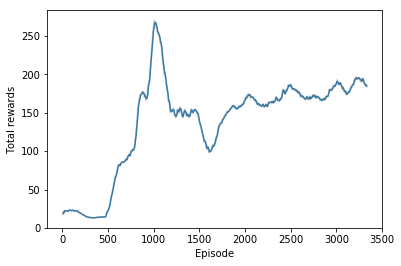

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

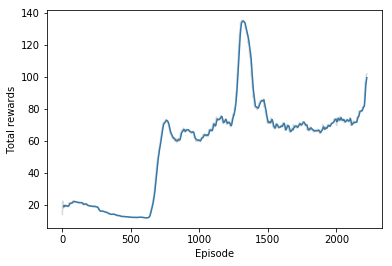

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

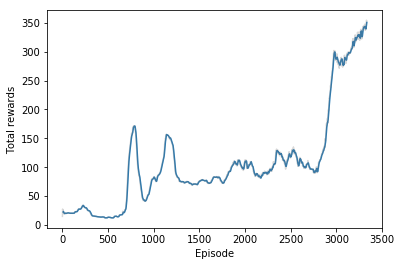

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

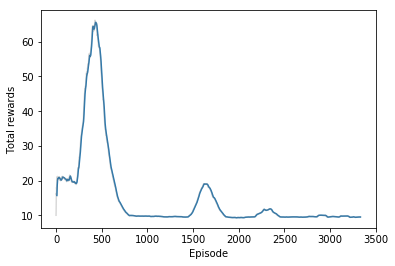

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

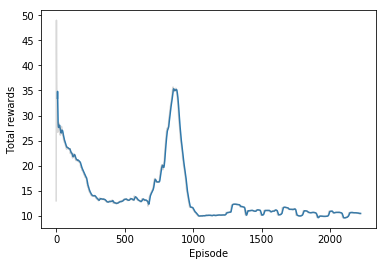

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

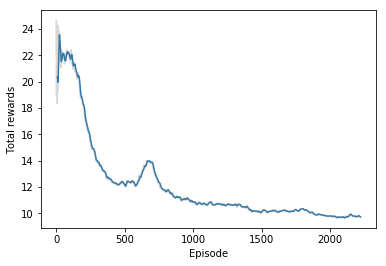

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

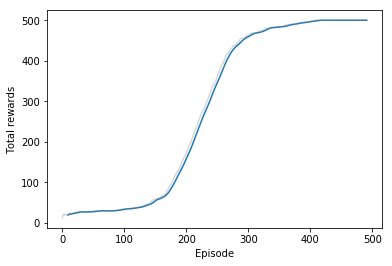

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

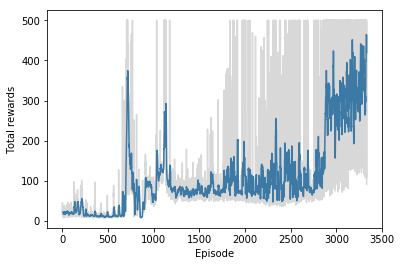

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

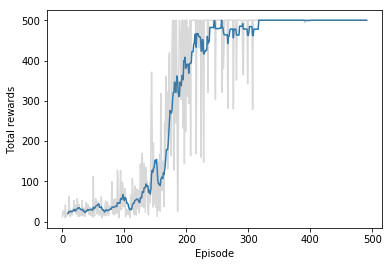

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.